In [11]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import fAux
import mc_permutation
import detrendPrice 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight


from xgboost import XGBClassifier, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr

import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols)



In [12]:
spy = pd.read_csv('data/spy.csv', index_col='date', parse_dates=True)
nvda = pd.read_csv('data/nvda.csv', index_col='date', parse_dates=True)
nvda.head()

,close,high,low,open,volume,ticker
date,,,,,,
1999-01-22,0.037609,0.044772,0.035579,0.040116,2714688000,nvda
1999-01-25,0.041549,0.042026,0.037609,0.040594,510480000,nvda
1999-01-26,0.038325,0.042862,0.037728,0.042026,343200000,nvda
1999-01-27,0.038206,0.039400,0.036295,0.038444,244368000,nvda
1999-01-28,0.038086,0.038444,0.037848,0.038206,227520000,nvda


In [13]:
# model for longing; trading at open tomorrow (t+1)
# based on today's data (ohlcv and more), decide whether to long tomorrow
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    df = df.copy()
    entry_price = df['open'].shift(-1) # trade at open next day
    future_max = df['close'].shift(-1).rolling(window=lookahead).max() # future max close 
    future_return = (future_max - entry_price) / entry_price
    df['target_long'] = (future_return >= threshold).astype(int)
    return df


def feature_engineering(df): # for trading at open tomorrow
    df = df.copy()
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']
    # Add more features as needed
    df.dropna(inplace=True)
    return df


def feature_engineering_2(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()
    spy_ret5 = spy['close'].pct_change(periods=5).fillna(0)
    df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')
    df.dropna(inplace=True)
    return df


def plot_model_metrics(y_true, y_proba):
    y_pred = (y_proba >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])

    plt.tight_layout()
    plt.show()


def eval_pipe(X, y, pipe, n_split=5, predict_proba_threshold=0.5):
    '''
    for evaluations on train set, make sure X and y does not contain anything from the test set (future data), 
    and use n_split=5 for 5-fold time series cross-validation
    '''
    tscv = TimeSeriesSplit(n_splits=n_split)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= predict_proba_threshold).astype(int)

        print(f'Fold {i+1}:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            plot_model_metrics(y_test, y_proba)

def pred_proba_to_signal(y_proba, threshold=0.5):
    """
    Convert predicted probabilities to binary signals.
    1 if probability >= threshold, else 0.
    returns a Series of signals.
    """
    return (y_proba >= threshold).astype(int)


def entry_exit(df): 
    '''
    takes in the ohlcv dataframe with model signals,
    returns a df that contains entry and exit dates, prices, returns, and holding days
    '''
    trades = []
    i = 0
    n = len(df)

    while i < n - 6:  # we need at least 5 days ahead, plus trading at open tomorrow
        if df['model_signal'].iloc[i] == 1:
            entry_date = df.index[i+1]
            entry_price = df['open'].iloc[i+1]
            exit_price = None
            exit_date = None
            holding = None
            exit_reason = None

            for j in range(1, 6):  # check up to 5 days ahead
                if i + 1 + j >= n:
                    break

                next_price = df['open'].iloc[i + 1 + j]
                ret = (next_price - entry_price) / entry_price

                # Exit Conditions
                if ret >= 0.02:  # profit target
                    exit_price = next_price
                    exit_date = df.index[i + 1 + j]
                    holding = j
                    exit_reason = 'profit_target'
                    break
                elif ret <= -0.02:  # stop loss
                    exit_price = next_price
                    exit_date = df.index[i + 1 + j]
                    holding = j
                    exit_reason = 'stop_loss'
                    break
                elif df['open'].iloc[i + 1 + j] >= df['sma30'].iloc[i + 1 + j]:  # revert to SMA30
                    exit_price = next_price
                    exit_date = df.index[i + 1 + j]
                    holding = j
                    exit_reason = 'revert_to_sma30'
                    break

            if exit_price is None:
                # Max holding (5th day)
                exit_price = df['open'].iloc[i + 1 + 5]
                exit_date = df.index[i + 1 + 5]
                holding = 5

            trade_return = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'return': trade_return,
                'holding_days': holding,
                'exit_reason': exit_reason
            })

            i = i + holding  # skip to the day after exit
        else:
            i += 1

    return pd.DataFrame(trades)


In [14]:
# baseline model; adapted from bb-rsi-try.ipynb

df = nvda.copy()
df = create_target_long(df, threshold=0.02, lookahead=5)
df = feature_engineering_2(feature_engineering(df))
X = df.drop(columns=['target_long','ticker'])
y = df['target_long']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [15]:
feats_gen1 = [
    'volume',               
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14',
    'prod_bollingerz_rsi',
    'rolling_volatility14',
    'atr',
    'spy_ret5'
]

# for xgb
ct_xgb1 = make_column_transformer(
    ('passthrough', feats_gen1),  
    remainder='drop'  
)

pipe_xgb1 = Pipeline([
    ('ct', ct_xgb1),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60       414
           1       0.64      0.64      0.64       466

    accuracy                           0.62       880
   macro avg       0.62      0.62      0.62       880
weighted avg       0.62      0.62      0.62       880

Fold 1 visualized below


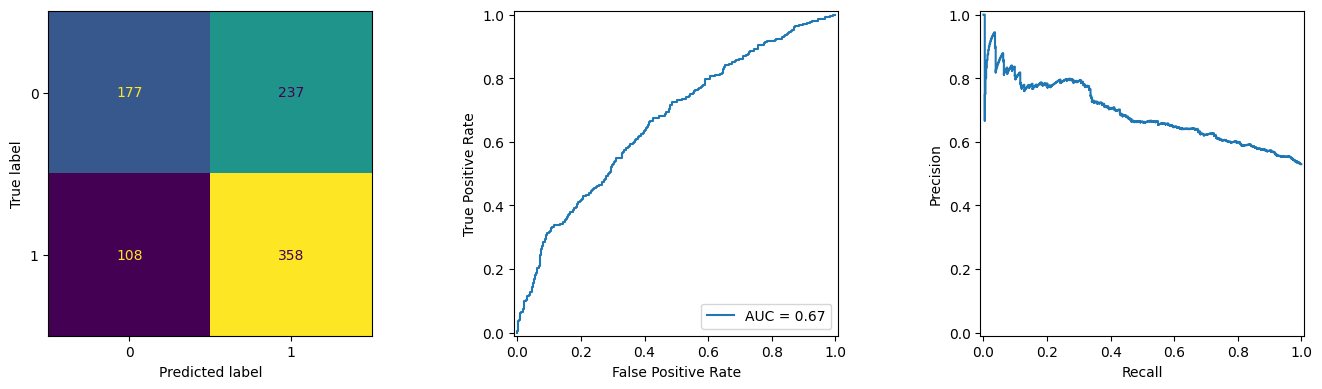

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       351
           1       0.74      0.71      0.72       529

    accuracy                           0.67       880
   macro avg       0.66      0.66      0.66       880
weighted avg       0.68      0.67      0.67       880

Fold 3:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       431
           1       0.71      0.68      0.69       449

    accuracy                           0.70       880
   macro avg       0.70      0.70      0.70       880
weighted avg       0.70      0.70      0.70       880



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       615
           1       0.64      0.48      0.55       265

    accuracy                           0.76       880
   macro avg       0.72      0.68      0.69       880
weighted avg       0.75      0.76      0.75       880

Fold 5:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       502
           1       0.63      0.71      0.67       378

    accuracy                           0.70       880
   macro avg       0.70      0.70      0.70       880
weighted avg       0.70      0.70      0.70       880



In [16]:
eval_pipe(X_train, y_train, pipe_xgb1, predict_proba_threshold=0.7)

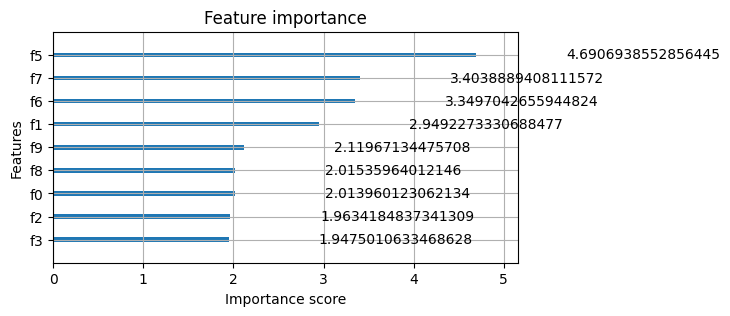

In [17]:
# check feature importance
fig, ax = plt.subplots(figsize=(6,3)) 
xgb1 = pipe_xgb1.named_steps['xgb']
plot_importance(xgb1, importance_type='gain', max_num_features=20, ax=ax)
plt.show()

In [18]:
# hyperparameter tuning
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 300, 500],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}

rscv_xgb1 = RandomizedSearchCV(
    pipe_xgb1,
    param_distributions=param_grid,
    n_iter=30,  # number of random combinations to try
    scoring='f1',  # or 'roc_auc', 'accuracy', etc.
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run search
rscv_xgb1.fit(X_train, y_train)

# Best model
print("Best Parameters:")
print(rscv_xgb1.best_params_)

print("\nBest Score:")
print(rscv_xgb1.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best Parameters:
{'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.5}

Best Score:
0.6116949546657906


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:15:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# backtest
y_proba_xgb1 = rscv_xgb1.predict_proba(X_test)[:, 1]
signals_xgb1 = pred_proba_to_signal(y_proba_xgb1, threshold=0.7)
X_test_signal_xgb1 = X_test.copy().assign(model_signal=signals_xgb1, y_proba=y_proba_xgb1)
trades_xgb1 = entry_exit(X_test_signal_xgb1)
print(trades_xgb1.shape)
print(trades_xgb1['exit_reason'].value_counts()) # 3 possible outcomes: profit_target, stop_loss, revert_to_sma30
print(trades_xgb1['holding_days'].value_counts())
trades_xgb1[20:30]  # display some trades

(51, 7)
exit_reason
profit_target    35
stop_loss        16
Name: count, dtype: int64
holding_days
1    34
2    13
4     3
3     1
Name: count, dtype: int64


,entry_date,exit_date,entry_price,exit_price,return,holding_days,exit_reason
20,2022-06-13,2022-06-17,15.976951,15.625461,-0.022000,4,stop_loss
21,2022-07-05,2022-07-06,14.154582,14.988381,0.058907,1,profit_target
22,2022-08-25,2022-08-26,16.819739,17.831282,0.060140,1,profit_target
23,2022-08-29,2022-08-31,15.996927,15.361840,-0.039701,2,stop_loss
24,2022-08-31,2022-09-01,15.361840,14.188533,-0.076378,1,stop_loss
25,2022-09-01,2022-09-06,14.188533,13.711222,-0.033641,2,stop_loss
26,2022-09-06,2022-09-09,13.711222,14.140810,0.031331,3,profit_target
27,2022-10-17,2022-10-18,11.504827,12.329884,0.071714,1,profit_target
28,2022-12-28,2022-12-29,13.914631,14.389209,0.034106,1,profit_target
29,2022-12-29,2023-01-03,14.389209,14.837810,0.031176,2,profit_target


In [31]:
# CAGR 
trades_xgb1['exit_date'] = pd.to_datetime(trades_xgb1['exit_date'])
trades_xgb1['entry_date'] = pd.to_datetime(trades_xgb1['entry_date'])

print('initial capital: 10000; always enter the trade with full capital amount')
capital = 10000 # initial capital
for r in trades_xgb1['return']:
    capital *= (1 + r)

# Calculate duration in years
start_date = trades_xgb1['entry_date'].iloc[0]
end_date = trades_xgb1['exit_date'].iloc[-1]
n_years = (end_date - start_date).days / 365.25
cagr = (capital / 10000) ** (1 / n_years) - 1
print(f'done {len(trades_xgb1)} trades over the course of {n_years:.3} years')
print(f'from {start_date.year}-{start_date.month} to {end_date.year}-{end_date.month}')
print(f'final capital: {capital}')
print(f"CAGR: {cagr:.2%}")

# SHARPE
mean_return_xgb1 = trades_xgb1['return'].mean()
std_return_xgb1 = trades_xgb1['return'].std()
sharpe_xgb1 = mean_return_xgb1 / std_return_xgb1
print(f'sharpe ratio: {sharpe_xgb1:.4}')

print(f"win rate: {len(trades_xgb1[trades_xgb1['return'] > 0]) / len(trades_xgb1):.2%}")

initial capital: 10000; always enter the trade with full capital amount
done 51 trades over the course of 4.58 years
from 2020-9 to 2025-4
final capital: 26385.971685277636
CAGR: 23.58%
sharpe ratio: 0.3457
win rate: 68.63%


### comment
- SHARPE ratio can be improved 

---
# refine the model

---
# ARCHIVE